In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('data/data_final.csv', 
                    parse_dates=['DateTime'])
df['DateTime'] = df['DateTime'].astype('datetime64[s]')
display(df.head())

print(f"Number of entries: {len(df)}")

,DateTime,pod1,pod2
0,2021-07-12 08:09:40,471740416,456708096.0
1,2021-07-12 08:09:50,471740416,456708096.0
2,2021-07-12 08:10:00,471740416,456708096.0
3,2021-07-12 08:10:10,321187840,408166400.0
4,2021-07-12 08:10:21,321187840,408166400.0


Number of entries: 17058


In [3]:
df_final = df.copy(deep=True)
df_final = df_final.drop(['pod1', 'pod2'], axis=1)
df_final['y'] = df['pod1'] + df['pod2']
df_final = df_final.drop(labels=[0,1], axis=0)
display(df_final.head())
print(f"Length of dataset: {len(df_final)}")

,DateTime,y
2,2021-07-12 08:10:00,928448512.0
3,2021-07-12 08:10:10,729354240.0
4,2021-07-12 08:10:21,729354240.0
5,2021-07-12 08:10:31,729354240.0
6,2021-07-12 08:10:41,631693312.0


Length of dataset: 17056


Length of dataset: 96


,y
DateTime,
2021-07-12 08:30:00,686755840.0
2021-07-12 09:00:00,673185792.0
2021-07-12 09:30:00,690401280.0
2021-07-12 10:00:00,709476352.0
2021-07-12 10:30:00,739880960.0


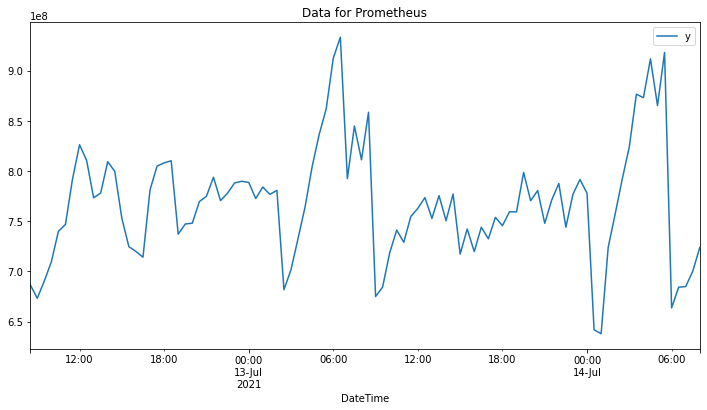

In [4]:
df_final = df_final.set_index('DateTime')
df_final = df_final.resample('30T').first()
df_final = df_final.iloc[1:]
df_final.plot(figsize=(12,6), title='Data for Prometheus')
print(f"Length of dataset: {len(df_final)}")
display(df_final.head())

In [5]:
dff = df_final.copy(deep=True)
dff = dff.reset_index()

display(dff.head())

date_rng = pd.date_range(start='2021-07-14 08:00:00', end='2021-08-03 07:30:00', freq='30T')
df_final = pd.DataFrame(date_rng, columns=['ds'])

dff_copy = dff.copy(deep=True)
dff_copy = dff_copy.drop('DateTime', axis=1)

dff_copy_final = pd.DataFrame()
for i in range(10):
    dff_copy_final = dff_copy_final.append(dff_copy, ignore_index=True)

display(dff_copy_final.head())
df_final['y'] = dff_copy_final['y']

df_final['datetime'] = pd.to_datetime(df_final['ds'])
df_final = df_final.drop('ds', axis=1)
df_final = df_final.set_index('datetime')
df_final.head()

,DateTime,y
0,2021-07-12 08:30:00,686755840.0
1,2021-07-12 09:00:00,673185792.0
2,2021-07-12 09:30:00,690401280.0
3,2021-07-12 10:00:00,709476352.0
4,2021-07-12 10:30:00,739880960.0


,y
0,686755840.0
1,673185792.0
2,690401280.0
3,709476352.0
4,739880960.0


,y
datetime,
2021-07-14 08:00:00,686755840.0
2021-07-14 08:30:00,673185792.0
2021-07-14 09:00:00,690401280.0
2021-07-14 09:30:00,709476352.0
2021-07-14 10:00:00,739880960.0


<AxesSubplot:xlabel='datetime'>

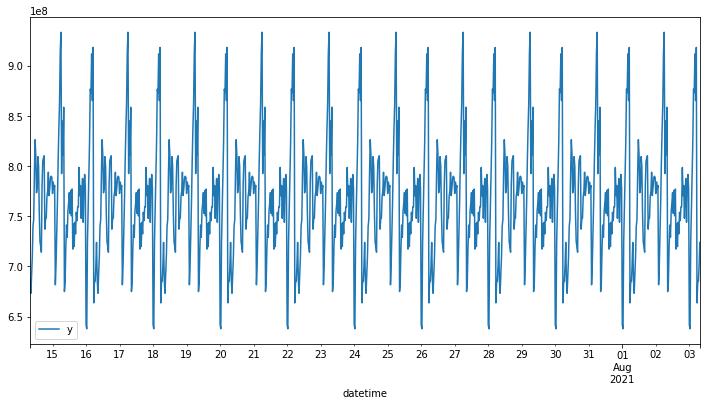

In [6]:
df_final.plot(figsize=(12,6))

In [7]:
df_final = df_final.resample('4H').first()
df_final = df_final.reset_index()
df_final = df_final.rename(columns={'datetime': 'ds'})

Length of Training set: 112
Length of Test set: 8


,y
ds,
2021-07-14 08:00:00,686755840.0
2021-07-14 12:00:00,810684416.0
2021-07-14 16:00:00,714137600.0
2021-07-14 20:00:00,769556480.0
2021-07-15 00:00:00,772558848.0


,y
ds,
2021-08-02 00:00:00,772558848.0
2021-08-02 04:00:00,804372480.0
2021-08-02 08:00:00,858497024.0
2021-08-02 12:00:00,773476352.0
2021-08-02 16:00:00,743976960.0


<AxesSubplot:xlabel='ds'>

<AxesSubplot:xlabel='ds'>

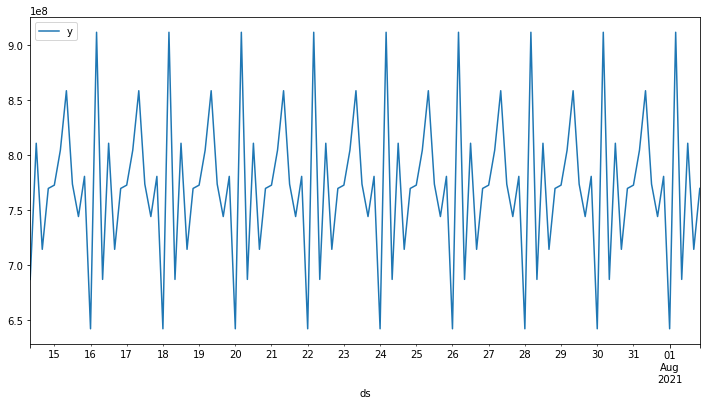

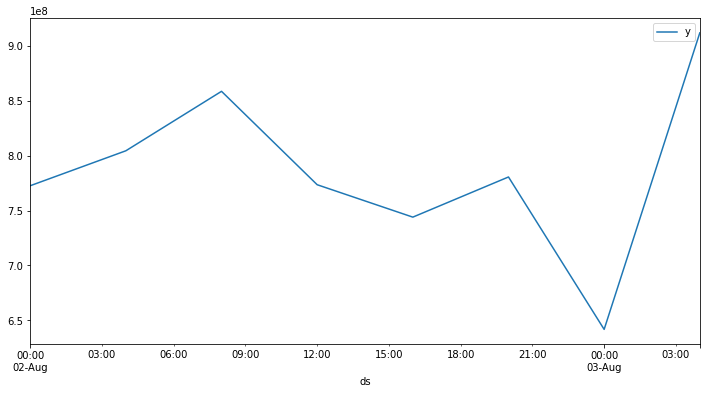

In [8]:
train = df_final.iloc[:112]
test = df_final.iloc[112:]

print(f"Length of Training set: {len(train)}")
print(f"Length of Test set: {len(test)}")

train = train.set_index('ds')
test = test.set_index('ds')
train = train.interpolate(method='linear')
display(train.head())
display(test.head())
display(train.plot(figsize=(12,6)))
display(test.plot(figsize=(12,6)))

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_data = train.values
test_data = test.values

scaler.fit(train_data)

train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# train_mean = train.mean()
# train_std = train.std()

# train = (train - train_mean) / train_std
# test = (test - train_mean) / train_std

In [10]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 5
generator = TimeseriesGenerator(train_data, train_data, length=n_input, batch_size=1)
print(len(generator))
X,y = generator[0]
print(X.flatten())
print(y)

107
[0.16652755 0.6256962  0.26797991 0.47331279 0.48443689]
[[0.60230981]]


In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [12]:
n_features = 1
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [14]:
import tensorflow as tf 

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(generator, epochs=20, callbacks=[callback])

Epoch 1/20
107/107 [==============================] - 15s 3ms/step - loss: 0.1267
Epoch 2/20
107/107 [==============================] - 0s 3ms/step - loss: 0.0759
Epoch 3/20
107/107 [==============================] - 0s 3ms/step - loss: 0.0667
Epoch 4/20
107/107 [==============================] - 0s 3ms/step - loss: 0.0775
Epoch 5/20
107/107 [==============================] - 0s 3ms/step - loss: 0.0658
Epoch 6/20
107/107 [==============================] - 0s 3ms/step - loss: 0.0665
Epoch 7/20
107/107 [==============================] - 0s 3ms/step - loss: 0.0552
Epoch 8/20
107/107 [==============================] - 0s 3ms/step - loss: 0.0326
Epoch 9/20
107/107 [==============================] - 0s 3ms/step - loss: 0.0358
Epoch 10/20
107/107 [==============================] - 0s 3ms/step - loss: 0.0364
Epoch 11/20
107/107 [==============================] - 0s 3ms/step - loss: 0.0339
Epoch 12/20
107/107 [==============================] - 0s 3ms/step - loss: 0.0304
Epoch 13/20
107/107 [===

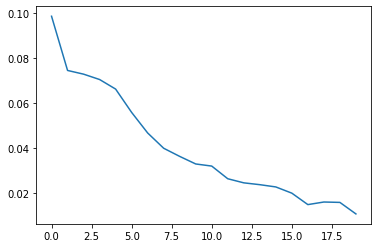

In [15]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [16]:
last_train_batch = train_data[-5:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

model.predict(last_train_batch)

array([[0.5244373]], dtype=float32)

In [17]:
test_data[0]

array([0.48443689])

In [18]:
import numpy as np 

test_predictions = []

first_eval_batch = train_data[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)): 
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    # append the prediction into the array
    test_predictions.append(current_pred) 
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [19]:
len(test_predictions)

8

In [20]:
true_predictions = scaler.inverse_transform(test_predictions)

In [21]:
test['Predictions'] = true_predictions

In [22]:
test.tail()

,y,Predictions
ds,,
2021-08-02 12:00:00,773476352.0,7.714298e+08
2021-08-02 16:00:00,743976960.0,7.617279e+08
2021-08-02 20:00:00,780529664.0,7.534829e+08
2021-08-03 00:00:00,641810432.0,7.596667e+08
2021-08-03 04:00:00,911708160.0,7.892925e+08


<AxesSubplot:xlabel='ds'>

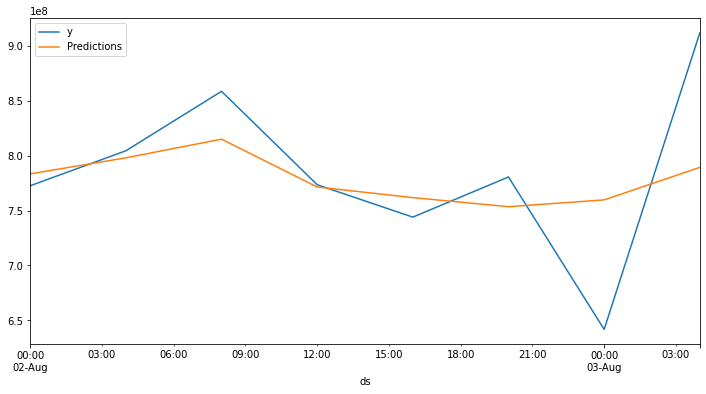

In [23]:
test.plot(figsize=(12,6))

In [1]:
from kafka import KafkaProducer
import json

producer = KafkaProducer(bootstrap_servers='192.168.1.7:9092',
                         value_serializer=lambda v: json.dumps(v).encode('utf-8'))

producer.send('predictions', {'predictions': [773476352,743976960,780529664]})